This notebook contains 
- code to connect to the AWS-hosted Parquet columnar
- information about downloading part of the index
- code to filter the local index and download WARC records
- information to re-index the local WARC files created by the downloaded WARC records

In [2]:
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import cdx_toolkit as cdxt
from tqdm import tqdm
import pandas as pd
import s3fs

# replace the following location with the folder where you will download parts of the index
WORKING_DATA_FOLDER = '/myhome/data/parquets/'

# Index download

The following code provides an example to connect to the S3 filesystem.

With the connection in place, a table is created and used to identify the index fragments (Parquet files) for download.

In this case, this was all the fragments that contained *.ke* URIs between 2022 and 2025.

In [2]:
# replace the access keys with your own
AWS_SERVER_PUBLIC_KEY='YOURPK'
AWS_SERVER_SECRET_KEY='YOURSK'

CC_INDEX_S3_PATH = 'commoncrawl/cc-index/table/cc-main/warc/'

In [3]:
s3 = s3fs.S3FileSystem(key=AWS_SERVER_PUBLIC_KEY, secret=AWS_SERVER_SECRET_KEY)

cc_index = ds.dataset(CC_INDEX_S3_PATH, filesystem=s3, format='parquet', partitioning='hive')

In [4]:
crawl_releases = []
for year in range(2022,2025):
    for week in range(0, 52):
        crawl_releases.append(f'CC-MAIN-{year}-{week:02d}')

In [8]:
# fragments are Parquet files that comprise the columnar
fragments = list(
    cc_index.get_fragments(
        filter=(
            ds.field('crawl').isin(crawl_releases) &
            # ds.field('subset').is_null() &
            (ds.field('subset') == 'warc')
        )
    )
)

In [7]:
len(fragments)

4203

In [9]:
records=[]
failed_rowgroups = 0
# Metadata from fragments is collected
# it will be used to select useful fragments
for fragment in tqdm(fragments):
    if fragment.path.endswith('.parquet'):
        for rowgroup in fragment.row_groups:
            try:
                rowg_saved_info = {'fragment':fragment.path}
                
                rowg_stats = rowgroup.statistics
                rowg_saved_info['min_url'] = rowg_stats['url_surtkey']['min'].split(')')[0]
                rowg_saved_info['max_url'] = rowg_stats['url_surtkey']['max'].split(')')[0]
                
                records.append(rowg_saved_info)
            except KeyError:
                failed_rowgroups+=1

100%|███████████████████████████████████████| 4203/4203 [19:17<00:00,  3.63it/s]


In [10]:
# failed_rowgroups

3

In [11]:
# len(records)

27230

In [12]:
frags_rowg_urls = pd.DataFrame.from_records(records)

In [14]:
frags_rowg_urls.query('min_url <= "ke.." & max_url >= "ke"').fragment.unique().shape

(17,)

In this case, only websites with *.ke* top-level-domain were needed.

This resulted in 17 relevant fragments.

Each fragment can be downloaded via CLI wget command. The following commented code block is an example of UK fragments download on a Ubuntu machine. Adapt the code for your specific operating system by uncommenting and adapting to your needs.

In [ ]:
# some_UK_fragments = ['commoncrawl/cc-index/table/cc-main/warc/crawl=CC-MAIN-2022-05/subset=warc/part-00064-1e2959d8-5649-433a-b76e-f1b876a6479d.c000.gz.parquet',
#        'commoncrawl/cc-index/table/cc-main/warc/crawl=CC-MAIN-2022-05/subset=warc/part-00089-1e2959d8-5649-433a-b76e-f1b876a6479d.c000.gz.parquet']

# for parquet in some_UK_fragments:
#     parquet_filename = parquet.split("/")[-1]
#     !curl -o {working_data_folder + 'uk/' + parquet_filename} {parquet.replace("commoncrawl", "https://data.commoncrawl.org")}

# Filtering

The goal of this section is to obtain a sample that contains enough companies, as domains, while discarding pages and domains which might slow down the analysis.

In [3]:
raw_ke_dataset = ds.dataset(WORKING_DATA_FOLDER + 'ke', format="parquet")
ke_dataset = raw_ke_dataset.filter(ds.field('url_host_tld') == 'ke')
co_ke_dataset = ke_dataset.filter(ds.field('url_host_2nd_last_part') == 'co')

In [4]:
filtering_columns = ['url', 'url_host_name', 'fetch_time', 'fetch_status', 'content_mime_type', 'warc_filename', 'warc_record_offset', 'warc_record_length']

# The machine had enough memory to process the table in memory, so Pandas was used instead of pyarrow.
# If this is not the case, refer to pyarrow's "iterative reads" functionality via .to_batches
co_ke_df = co_ke_dataset.to_table(columns=filtering_columns).to_pandas()

co_ke_df['year'] = co_ke_df['fetch_time'].dt.year

co_ke_filtered = co_ke_df.query('(year == 2024) & (~url.str.contains("robots.txt")) & (fetch_status == 200) & (content_mime_type == "text/html")')

co_ke_filtered.url_host_name.nunique()

12215

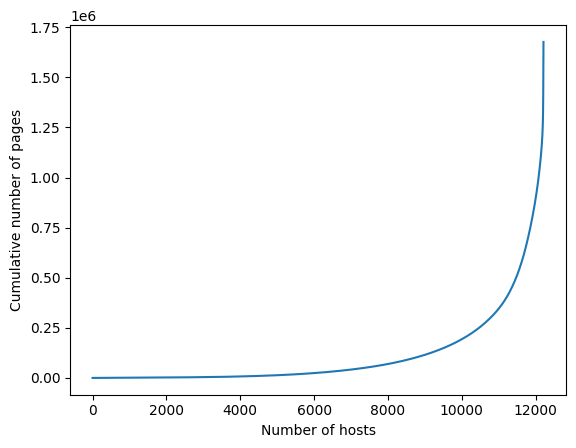

In [8]:
co_ke_page_counts = co_ke_filtered.url_host_name.value_counts()

co_ke_page_counts.sort_values().cumsum().reset_index(drop=True).plot(xlabel="Number of hosts", ylabel="Cumulative number of pages").get_figure().savefig('cumulative_page_dist.png')

In [7]:
bottom_10k_domains = co_ke_page_counts.sort_values().head(int(1e4))
bottom_10k_domains.sum()

192900

The arbitrary cutoff of 10000 domains prevents the number of pages from exploding.

In [8]:
rename_dict = {
    'warc_filename':'filename',
    'warc_record_offset':'offset',
    'warc_record_length':'length'
}

In [9]:
to_download_pages = co_ke_filtered.query('url_host_name.isin(@bottom_10k_domains.index)').rename(rename_dict, axis=1)

# Pages download

With a filtered table of records, the download procedure uses `cdx-toolkit`'s methods.

In [10]:
warcinfo = {
    'software': 'dot_co_dot_ke sample export',
    'isPartOf': 'DOTCODOTKE-SAMPLE',
    'description': 'warc extraction of 10000 .co.ke domains, taken from commoncrawl as part of vittorio rossi\'s semester project',
    'format': 'WARC file version 1.0',
}

writer = cdxt.warc.get_writer('DOTCODOTKE', 'SAMPLE', warcinfo, warc_version='1.0')

In [11]:
cc_uri = 'https://data.commoncrawl.org'

In [ ]:
for i, row in to_download_pages.iterrows():
    record = cdxt.warc.fetch_warc_record(row, cc_uri)

    writer.write_record(record)

After downloading the required pages, a local index needs to be created.

This can be done via the command line on Linux with the `cdxj-indexer` package.
The created index file will be loaded in the _embedding_ notebook for processing of individual web pages.